In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc
import os


# 시각화 관련 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps") # 맥 GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0") # 윈도우 GPU
else:
    DEVICE = torch.device("cpu") # CPU

print(DEVICE)

# 캐시 지우기 함수 생성
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

# MallocStackLogging 에러 출력 방지
os.environ.pop("MallocStackLogging", None)
os.environ.pop("MallocStackLoggingNoCompact", None)
os.environ.pop("DYLD_INSERT_LIBRARIES", None)


# # 로그
# import logging

# def init_logger() -> logging.Logger:
#     logging.basicConfig(
#         format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
#         datefmt="%Y-%m-%d %H:%M:%S",
#         level=logging.INFO,
#         encoding="utf-8",
#     )
#     return logging.getLogger("")

# logger = init_logger()

Matplotlib is building the font cache; this may take a moment.


mps


In [3]:
import json

ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")
IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
ANNOT_DIR = os.path.join(DATA_DIR, "train_annotations")

full_dict_path = os.path.join(DATA_DIR, "FULL_DICT.json")
err_txt_path = os.path.join(DATA_DIR, "err_image_paths.txt")
fixed_dict_path = os.path.join(DATA_DIR, "FIXED_DICT.json")

FINAL_DICT = {}

# FULL_DICT 더하기
try:
    with open(full_dict_path, "r", encoding="utf-8") as f:
        FULL_DICT = json.load(f)
except:
    pass

for key, value in FULL_DICT.items():
    a = os.path.join(IMAGE_DIR, key)
    tmp_list = []
    for pa in value:
        tmp_list.append(os.path.join(ANNOT_DIR, pa))
    FINAL_DICT[a] = tmp_list


# err_image_paths 빼기
try:
    with open(err_txt_path, "r", encoding="utf-8") as f:
        err_image_paths = f.read().split()
    for err in err_image_paths:
        a = os.path.join(IMAGE_DIR, err)
        del FINAL_DICT[a]
except:
    pass


# FIXED_DICT 더하기
try:
    with open(fixed_dict_path, "r", encoding="utf-8") as f:
        FIXED_DICT = json.load(f)
    for key, value in FIXED_DICT:
        a = os.path.join(IMAGE_DIR, key)
        tmp_list = []
        for pa in value:
            tmp_list.append(os.path.join(ANNOT_DIR, pa))
        FINAL_DICT[a] = tmp_list
except:
    pass


for image_path, annot_paths in FINAL_DICT.items():

    tmp_list = []

    for path in annot_paths:
        bbox = []
        with open(path, "r", encoding="utf-8") as f:
            json_data = json.load(f)

        xywh_bbox = json_data["annotations"][0]["bbox"]

        tmp_list.append({"bbox": xywh_bbox,
                        "label": json_data["categories"][0]["id"]})
        
    FINAL_DICT[image_path] = tmp_list

len(FINAL_DICT)

215

In [4]:
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter

# YOLO 데이터셋 폴더 생성
YOLO_BASE_PATH = "./data/yolo_dataset"
os.makedirs(f"{YOLO_BASE_PATH}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/labels/val", exist_ok=True)

# 클래스 ID 매핑 생성 (category id -> 0부터 시작하는 인덱스)
unique_labels = set()
for annots in FINAL_DICT.values():
    for annot in annots:
        unique_labels.add(annot["label"])

label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print(f"총 클래스 수: {len(label_to_idx)}")
print(f"클래스 매핑: {label_to_idx}")

# -------------------------------------------------------------
# [수정] 층화 추출(Stratified Split)을 위한 전략 수립
# -------------------------------------------------------------

# 1. 모든 라벨 수집 및 빈도 계산
all_labels = []
image_paths = list(FINAL_DICT.keys())
path_to_rarest_label = {} # 각 이미지의 대표(희귀) 라벨 저장

# 전체 빈도수 미리 계산
total_label_list = []
for annots in FINAL_DICT.values():
    for annot in annots:
        total_label_list.append(annot["label"])
label_counts = Counter(total_label_list)

# 2. 각 이미지별 "가장 희귀한 라벨" 선정
stratify_labels = []
valid_image_paths = [] # 분할에 사용할 이미지 리스트

for path in image_paths:
    annots = FINAL_DICT[path]
    if not annots:
        # 배경 이미지는 -1로 처리
        rarest_label = -1
    else:
        # 이미지 내 객체 중 '전체 빈도수'가 가장 낮은 객체를 찾음
        # (빈도수, 라벨) 튜플을 만들어 min을 찾음
        img_label_counts = [(label_counts[annot["label"]], annot["label"]) for annot in annots]
        rarest_label_obj = min(img_label_counts, key=lambda x: x[0])
        rarest_label = rarest_label_obj[1] # 라벨 값만 추출

    # 매핑된 ID로 변환 (배경은 -1 유지)
    if rarest_label != -1:
        mapped_id = label_to_idx[rarest_label]
    else:
        mapped_id = -1
        
    path_to_rarest_label[path] = mapped_id
    valid_image_paths.append(path)
    stratify_labels.append(mapped_id)

# 3. [안전장치] 데이터 개수가 1개뿐인 클래스 처리
# stratify=y 옵션은 y의 각 클래스 데이터가 최소 2개 이상이어야 작동함 (하나를 train, 하나를 val에 넣어야 하므로)
stratify_counter = Counter(stratify_labels)
single_sample_classes = [lbl for lbl, cnt in stratify_counter.items() if cnt < 2]

train_imgs = []
val_imgs = []
remaining_imgs = []
remaining_labels = []

for path, label in zip(valid_image_paths, stratify_labels):
    if label in single_sample_classes:
        # 데이터가 1개뿐인 클래스는 무조건 Train에 넣음 (Val에 넣으면 학습을 못하므로)
        train_imgs.append(path)
    else:
        remaining_imgs.append(path)
        remaining_labels.append(label)

print(f"단일 샘플 클래스(무조건 Train행): {len(train_imgs)}개 이미지")

# 4. 남은 데이터로 층화 추출 수행
if remaining_imgs:
    X_train, X_val, _, _ = train_test_split(
        remaining_imgs, 
        remaining_labels, # y값만 필요함
        test_size=0.2, 
        random_state=42,
        stratify=remaining_labels # 희귀 라벨 기준 비율 유지
    )
    
    # 앞서 빼둔 단일 샘플들과 합치기
    train_images = train_imgs + X_train
    val_images = val_imgs + X_val
else:
    # 만약 모든 데이터가 단일 샘플이라면 (극단적 경우)
    train_images = train_imgs
    val_images = []

print(f"\n최종 분할 결과:")
print(f"Train 이미지: {len(train_images)}개")
print(f"Val 이미지: {len(val_images)}개")

def convert_to_yolo_format(bbox, img_width, img_height):
    """
    XYXY bbox를 YOLO format (normalized XYWH)으로 변환
    Args:
        bbox: [x1, y1, x2, y2]
        img_width, img_height: 이미지 크기
    Returns:
        [x_center, y_center, width, height] (normalized)
    """
    x, y, w, h = bbox
    
    # 중심점과 너비/높이 계산
    x_center = x + w/2
    y_center = y + h/2
    width = w
    height = h
    
    # 정규화 (0~1 범위)
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return [x_center, y_center, width, height]

def create_yolo_labels(image_paths, split='train'):
    """YOLO 라벨 파일 생성 및 이미지 복사"""
    for img_path in image_paths:
        # 이미지 크기 읽기
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # 이미지 파일명
        img_filename = os.path.basename(img_path)
        img_name = os.path.splitext(img_filename)[0]
        
        # 이미지 복사
        dst_img_path = f"{YOLO_BASE_PATH}/images/{split}/{img_filename}"
        shutil.copy(img_path, dst_img_path)
        
        # 라벨 파일 생성
        label_path = f"{YOLO_BASE_PATH}/labels/{split}/{img_name}.txt"
        
        with open(label_path, 'w') as f:
            annots = FINAL_DICT[img_path]
            for annot in annots:
                # 클래스 ID 변환
                class_id = label_to_idx[annot["label"]]
                
                # bbox를 YOLO 형식으로 변환
                yolo_bbox = convert_to_yolo_format(
                    annot["bbox"], 
                    img_width, 
                    img_height
                )
                
                # YOLO 형식으로 작성: <class> <x_center> <y_center> <width> <height>
                f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

# Train/Val 라벨 생성
print("\n라벨 파일 생성 중...")
create_yolo_labels(train_images, 'train')
create_yolo_labels(val_images, 'val')
print("완료!")

# YOLO data.yaml 파일 생성
data_yaml = {
    'path': os.path.abspath(YOLO_BASE_PATH),  # 데이터셋 루트 경로
    'train': 'images/train',  # train 이미지 경로
    'val': 'images/val',      # val 이미지 경로
    'nc': len(label_to_idx),  # 클래스 개수
    'names': idx_to_label     # 클래스 이름 (idx: label)
}

import yaml
with open(f"{YOLO_BASE_PATH}/data.yaml", 'w', encoding='utf-8') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, allow_unicode=True, sort_keys=False)

print(f"\nYOLO 데이터셋 준비 완료!")
print(f"경로: {YOLO_BASE_PATH}")
print(f"data.yaml 생성 완료")

총 클래스 수: 56
클래스 매핑: {1899: 0, 2482: 1, 3350: 2, 3482: 3, 3543: 4, 3742: 5, 3831: 6, 4542: 7, 12080: 8, 12246: 9, 12777: 10, 13394: 11, 13899: 12, 16231: 13, 16261: 14, 16547: 15, 16550: 16, 16687: 17, 18146: 18, 18356: 19, 19231: 20, 19551: 21, 19606: 22, 19860: 23, 20013: 24, 20237: 25, 20876: 26, 21324: 27, 21770: 28, 22073: 29, 22346: 30, 22361: 31, 24849: 32, 25366: 33, 25437: 34, 25468: 35, 27732: 36, 27776: 37, 27925: 38, 27992: 39, 28762: 40, 29344: 41, 29450: 42, 29666: 43, 30307: 44, 31862: 45, 31884: 46, 32309: 47, 33008: 48, 33207: 49, 33879: 50, 34596: 51, 35205: 52, 36636: 53, 38161: 54, 41767: 55}
단일 샘플 클래스(무조건 Train행): 2개 이미지

최종 분할 결과:
Train 이미지: 172개
Val 이미지: 43개

라벨 파일 생성 중...
완료!

YOLO 데이터셋 준비 완료!
경로: ./data/yolo_dataset
data.yaml 생성 완료


In [5]:
import torch
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics.data.build import InfiniteDataLoader
import random


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

class CustomSamplerTrainer(DetectionTrainer):
    def __init__(self, final_dict, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_dict = final_dict
        
    def get_dataloader(self, dataset_path, batch_size=16, rank=0, mode="train"):
        if mode != "train":
            return super().get_dataloader(dataset_path, batch_size, rank, mode)

        with torch.distributed.distributed_c10d.monitored_barrier() if torch.distributed.is_initialized() else torch.no_grad():
            dataset = self.build_dataset(dataset_path, mode, batch_size)
        
        # --- 가중치 계산 로직 (기존과 동일) ---
        all_labels_in_dict = []
        for info_list in self.final_dict.values():
            for obj in info_list:
                all_labels_in_dict.append(obj['label'])
        
        class_counts = Counter(all_labels_in_dict)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        
        filename_lookup = {os.path.basename(k): v for k, v in self.final_dict.items()}
        sample_weights = []
        
        # YOLO가 로드한 파일 리스트 순회
        for file_path in dataset.im_files:
            filename = os.path.basename(file_path) # 경로 떼고 파일명만 추출
            
            if filename in filename_lookup:
                objects = filename_lookup[filename] # 파일명으로 데이터 조회
                
                if not objects:
                    sample_weights.append(0.0)
                    continue
                
                # 라벨 ID 매핑 주의: 
                # FINAL_DICT에는 원래 라벨(예: 16547)이 들어있고,
                # 학습에는 매핑된 라벨(예: 0, 1)이 쓰이지만,
                # "빈도수 기반 가중치"를 계산하는 데는 원래 라벨을 써도 상관없습니다.
                # (희귀한 객체는 원래 ID로도 여전히 희귀하기 때문)
                
                current_img_weights = [class_weights.get(obj['label'], 0) for obj in objects]
                sample_weights.append(max(current_img_weights))
            else:
                # 매칭되지 않는 경우 (거의 없어야 정상)
                print(f"Warning: {filename} not found in lookup dict.")
                sample_weights.append(0.0)
        if sum(sample_weights) == 0:
            sample_weights = [1.0] * len(sample_weights)

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # 1. 일반 PyTorch DataLoader 생성
        generator = torch.Generator()
        generator.manual_seed(6148914691)
        
        loader = InfiniteDataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False, 
            sampler=sampler,
            num_workers=self.args.workers,
            collate_fn=getattr(dataset, 'collate_fn', None),
            pin_memory=True,
            worker_init_fn=seed_worker, # 시드 고정용 (선택사항)
            generator=generator
        )

        return loader

In [6]:
from ultralytics import YOLO

# YOLO 모델 로드 (사전학습된 모델)

model_name = 'yolov8s.pt' # 혹은 가지고 계신 가중치 경로

args = dict(
    model=model_name,
    data='./data/yolo_dataset/data.yaml',
    epochs=30,
    imgsz=512,
    batch=8,
    name='pill_y8s_512_aug1_light_with_sampler_no_aug',
    device=DEVICE,  # 'mps', 'cuda', 'cpu'

    # # 👇 여기부터 증강 세팅
    # # 기하학 변형
    # degrees=5.0,        # ±5도 회전 (촬영 각도 개인차)
    # translate=0.05,     # 5% 정도 평행 이동
    # scale=0.10,         # 10% 확대/축소
    # shear=0.0,          # 각인 찌그러짐 방지
    # perspective=0.0,    # 원근 왜곡 X
    # fliplr=0.0,         # 좌우반전 X (각인 방향 보존)
    # flipud=0.0,         # 상하반전 X

    # # 색/밝기 (ColorJitter + BrightnessContrast 느낌)
    # hsv_h=0.02,         # 색조 살짝 변화
    # hsv_s=0.30,         # 채도 적당히
    # hsv_v=0.20,         # 밝기 적당히

    # # 모자이크/믹스업 등
    # mosaic=0.05,        # 살짝만 사용 (데이터 적어서 과하면 위험)
    # mixup=0.0,
    # erasing=0.0,
    # auto_augment=None,
    # workers=2
)

# 3. 커스텀 트레이너로 학습 시작
trainer = CustomSamplerTrainer(final_dict=FINAL_DICT, overrides=args)
trainer.train()

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pill_y8s_512_aug1_light_with_sampler_no_aug, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=N

/Users/won/dev/codeit/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/notebooks/runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000167, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/notebooks/runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/30       3.5G      1.132      4.951      1.196         46        512: 100% ━━━━━━━━━━━━ 26/26 1.2it/s 20.9s0.8ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.6s/it 7.9s2.0ss


/Users/won/dev/codeit/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


      21/30       3.4G     0.2988     0.6034      0.824         25        512: 100% ━━━━━━━━━━━━ 26/26 1.0it/s 25.6s1.0ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.8s/it 8.8s2.4ss
                   all         78        261      0.948      0.977      0.995      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30       3.4G     0.2826     0.5744     0.8229         27        512: 100% ━━━━━━━━━━━━ 26/26 1.2it/s 21.8s0.8ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.1s/it 10.6s.0ss
                   all         78        261      0.958      0.976      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30       3.4G     0.2852     0.5375     0.8343         27        512: 100% ━━━━━━━━━━━━ 26/26 1.1it/s 22.6s0.9ss
                 Class     Images  Ins

📁 최신 train run 선택: ./runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug


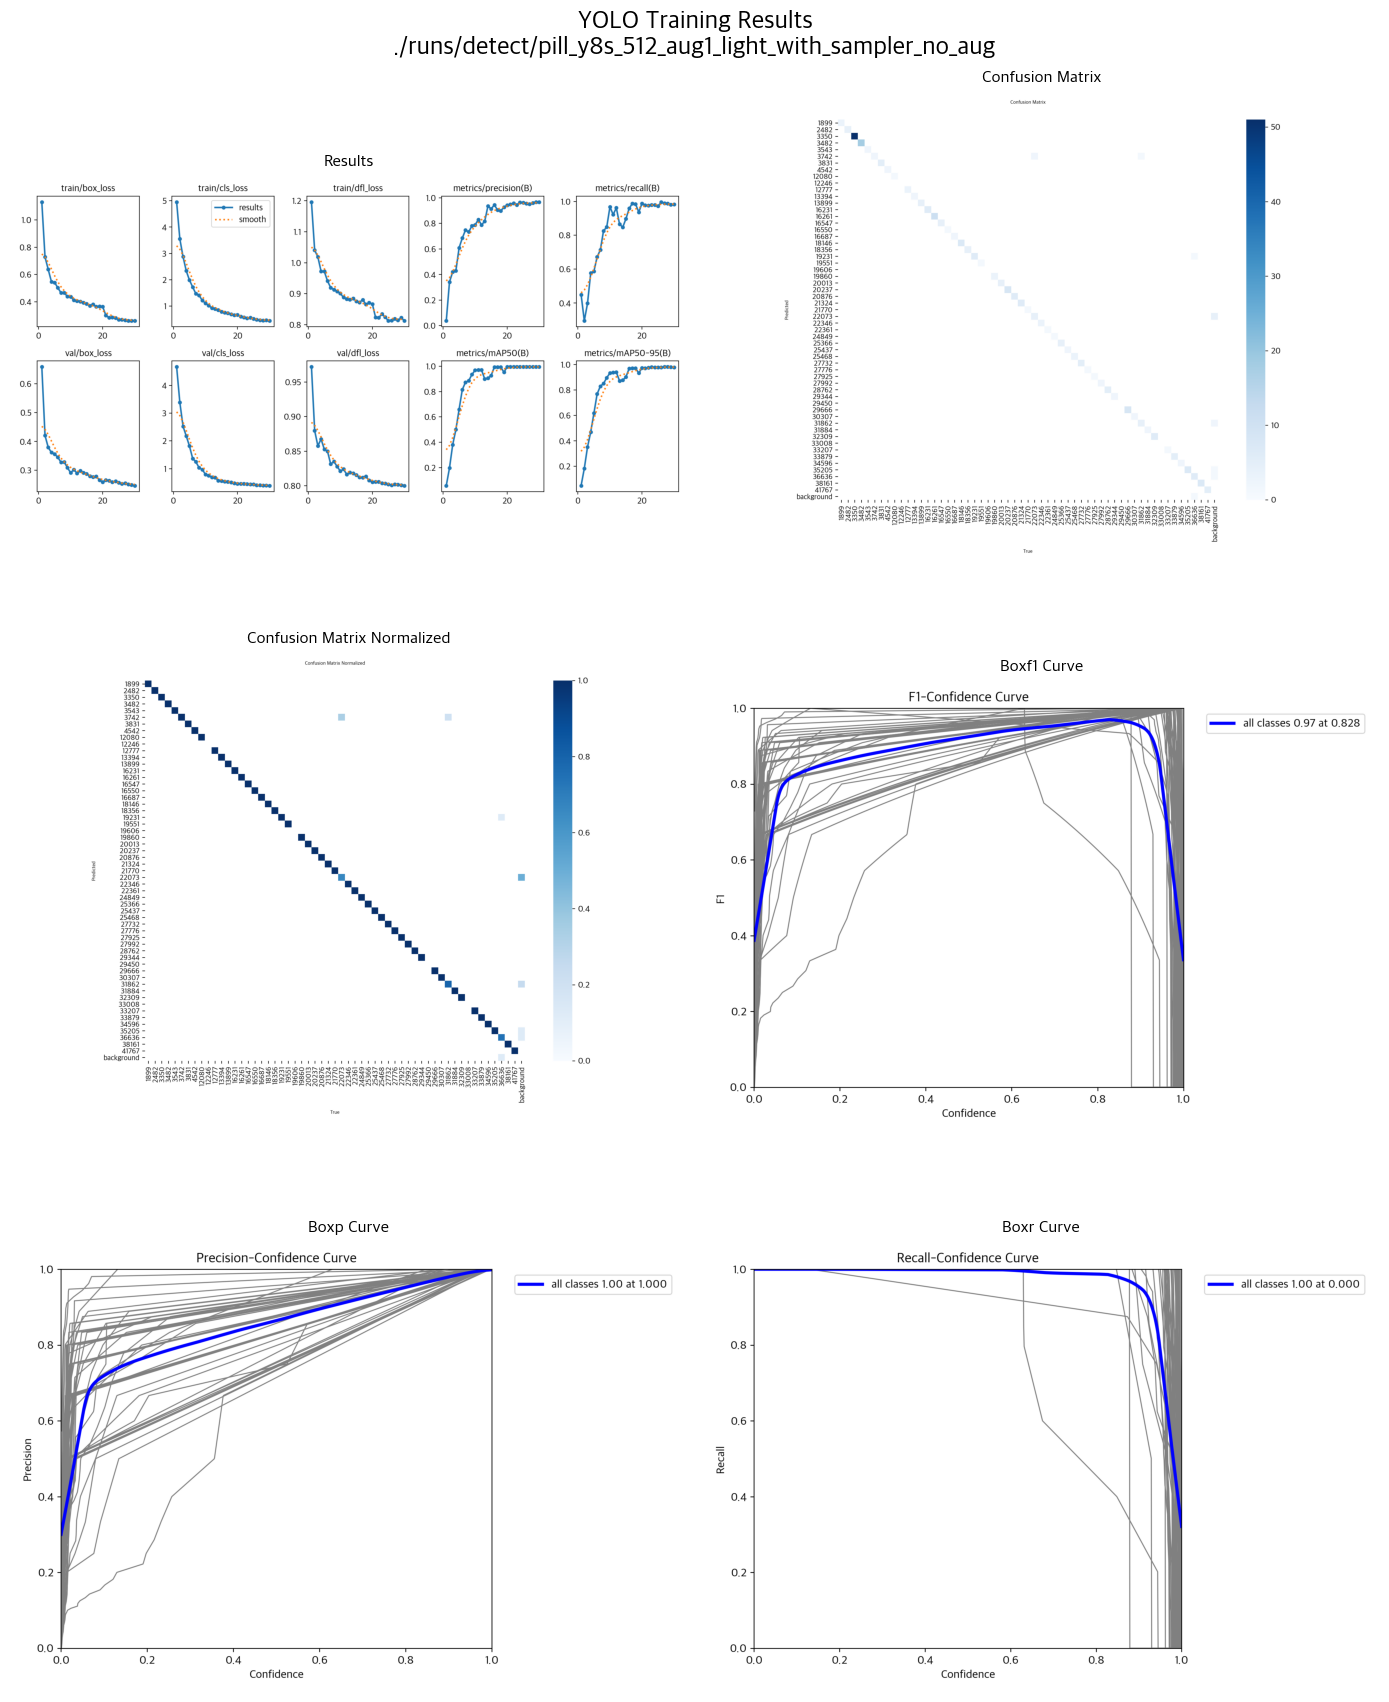

In [4]:
# 학습 결과 그래프 표시
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

def show_latest_training_results():
    """
    ./runs/detect 안에서 'predict', 'val'을 제외한
    가장 최근 train run을 고르고,
    metric 이미지를 2개씩 한 줄에 시각화.
    """
    # 1) train run 폴더만 모으기
    run_dirs = []
    for d in glob.glob('./runs/detect/*'):
        if not os.path.isdir(d):
            continue
        name = os.path.basename(d).lower()
        if 'predict' in name or name == 'val':
            continue
        run_dirs.append(d)

    if not run_dirs:
        print("⚠️ 학습(run) 폴더를 찾지 못했어요.")
        return

    # 2) 가장 최근 train run 선택
    latest_run = sorted(run_dirs, key=os.path.getmtime)[-1]
    print(f"📁 최신 train run 선택: {latest_run}")

    # 3) 사용할 metric 이미지 후보
    candidates = [
        'results.png',
        'confusion_matrix.png',
        'confusion_matrix_normalized.png',
        'BoxF1_curve.png',
        'BoxP_curve.png',
        'BoxR_curve.png',
    ]
    metric_images = [img for img in candidates
                     if os.path.exists(os.path.join(latest_run, img))]

    if not metric_images:
        print("⚠️ 표시할 metric 이미지가 없어요.")
        return

    # 4) 2개씩 한 줄에 배치
    n = len(metric_images)
    cols = 2
    rows = (n + cols - 1) // cols  # 올림

    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)  # (2,) -> (1,2)

    fig.suptitle(f'YOLO Training Results\n{latest_run}',
                 fontsize=18, fontweight='bold')

    for idx, img_name in enumerate(metric_images):
        r = idx // cols
        c = idx % cols
        ax = axes[r, c]

        img_path = os.path.join(latest_run, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_name.replace('.png', '').replace('_', ' ').title())
        ax.axis('off')

    # 남는 칸은 숨기기
    for idx in range(len(metric_images), rows * cols):
        r = idx // cols
        c = idx % cols
        axes[r, c].axis('off')

    plt.tight_layout()
    display(fig)
    plt.close(fig)

# 실행
show_latest_training_results()

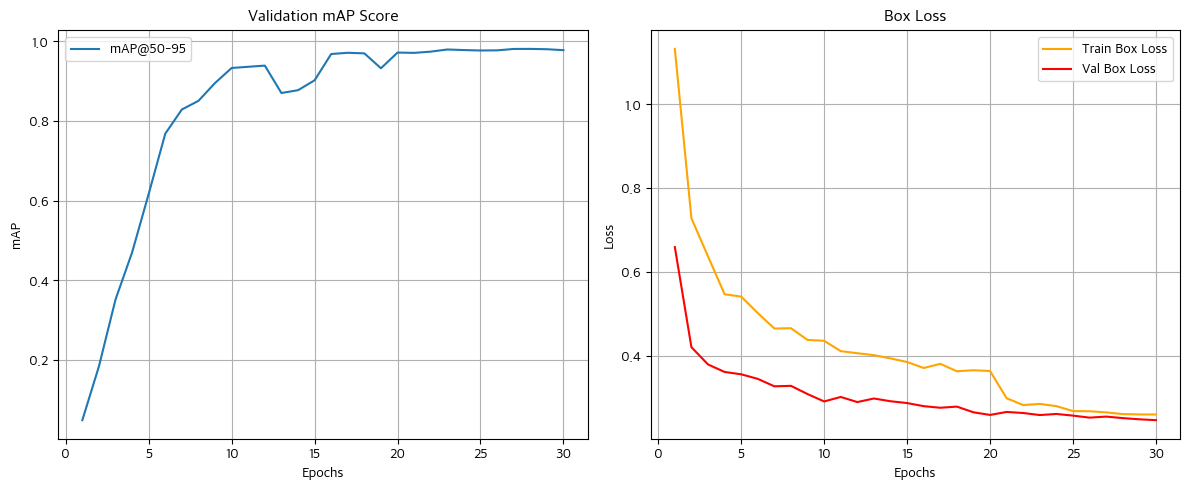

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. results.csv 읽기 (경로 수정 필요)
df = pd.read_csv('runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug/results.csv')

# 컬럼명 공백 제거 (YOLO csv는 컬럼명 앞에 공백이 있을 수 있음)
df.columns = [col.strip() for col in df.columns]

# 2. 그래프 그리기 (예: mAP50-95 와 train/box_loss)
plt.figure(figsize=(12, 5))

# mAP@50-95 (전체적인 성능 지표)
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.title('Validation mAP Score')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.grid(True)
plt.legend()

# Train Box Loss (학습이 잘 되고 있는지)
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='orange')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
plt.title('Box Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


image 1/1 /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/data/train_images/K-001900-016548-019607-029345_0_2_0_2_75_000_200.png: 512x416 1 1899, 1 16547, 1 19606, 1 29344, 69.9ms
Speed: 2.5ms preprocess, 69.9ms inference, 5.1ms postprocess per image at shape (1, 3, 512, 416)
Results saved to /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/notebooks/runs/detect/predict7


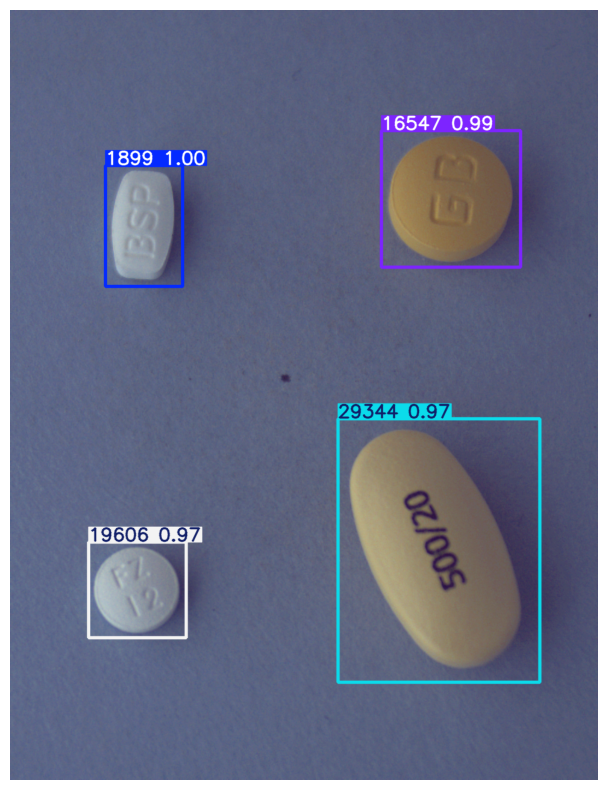


=== 예측 결과 상세 정보 ===
객체: 1899 | 신뢰도: 1.00 | 좌표: (158.9, 258.6, 286.9, 459.1)
객체: 16547 | 신뢰도: 0.99 | 좌표: (616.7, 200.8, 848.0, 427.0)
객체: 29344 | 신뢰도: 0.97 | 좌표: (544.7, 679.4, 879.3, 1117.2)
객체: 19606 | 신뢰도: 0.97 | 좌표: (130.1, 884.2, 292.1, 1043.1)


In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import random
import glob
import os

# 1. 학습된 모델 로드 (경로는 본인의 runs 폴더 확인 필요)
# 보통 'runs/detect/train/weights/best.pt' 에 저장됩니다.
model = YOLO('runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug/weights/best.pt')

rand_index = random.randint(1, len(glob.glob(os.path.join(IMAGE_DIR, "*.png"))))

# 2. 예측할 이미지 경로
# (테스트하고 싶은 이미지 경로를 입력하세요)
source_img_path = glob.glob(os.path.join(IMAGE_DIR, "*.png"))[rand_index-1]

# 3. 예측 실행 (conf: 확신 임계값, save: 결과 이미지 저장 여부)
results = model.predict(source_img_path, conf=0.5, save=True)

# ---------------------------------------------------------
# [시각화] 예측 결과 이미지 화면에 띄우기
# ---------------------------------------------------------
for result in results:
    # result.plot()은 BGR(Opencv 포맷)로 된 numpy array를 반환합니다.
    plotted_img = result.plot()
    
    # Matplotlib 출력을 위해 BGR -> RGB 변환
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# ---------------------------------------------------------
# [텍스트 출력] 좌표, 클래스, 정확도 출력
# ---------------------------------------------------------
print("\n=== 예측 결과 상세 정보 ===")
for result in results:
    boxes = result.boxes  # 감지된 박스들
    
    for box in boxes:
        # 1. 좌표 (x1, y1, x2, y2)
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        
        # 2. 클래스 이름
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        
        # 3. 신뢰도 (Confidence Score)
        conf = float(box.conf[0])
        
        print(f"객체: {cls_name} | 신뢰도: {conf:.2f} | 좌표: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

In [10]:
import os
import glob
import yaml
import pandas as pd
from ultralytics import YOLO

# 1. 경로 설정 (프로젝트 구조에 맞게 조정)
ROOT_DIR = os.path.dirname(os.getcwd())          # notebooks 기준 한 단계 위
DATA_DIR = os.path.join(ROOT_DIR, "data")
TEST_DIR = os.path.join(DATA_DIR, "test_images") # 테스트 이미지 폴더 이름 확인!
MODEL_PATH = os.path.join(os.getcwd(), "runs", "detect", "pill_y8s_512_aug1_light_with_sampler_no_aug", "weights", "best.pt")
DATA_YAML_PATH = os.path.join(os.getcwd(), "data", "yolo_dataset", "data.yaml")
print("ROOT_DIR :", ROOT_DIR)
print("TEST_DIR :", TEST_DIR)
print("MODEL_PATH :", MODEL_PATH)
print("DATA_YAML_PATH :", DATA_YAML_PATH)

# 2. data.yaml에서 idx -> category_id
with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_cfg = yaml.safe_load(f)
names = data_cfg["names"]   # {0: 1899, 1: 2482, ...}[file:24]

# 3. 테스트 이미지 목록 (파일 이름 기준)
test_image_paths = glob.glob(os.path.join(TEST_DIR, "*.png"))

# 파일명에서 숫자만 뽑아서 정렬 기준으로 사용
test_image_paths = sorted(
    test_image_paths,
    key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))

# 4. 모델 로드 & 예측
model = YOLO(MODEL_PATH)
results = model(test_image_paths, conf=0.25, iou=0.5, verbose=False)

# 5. 결과 → submission rows
rows = []
ann_id = 1

for img_path, res in zip(test_image_paths, results):
    fname = os.path.basename(img_path)         # "3.png", "10.png" 그대로
    image_id = int(os.path.splitext(fname)[0]) # "3" -> 3, "10" -> 10
    ...
    # 1, 3, 4, ...

    if res.boxes is None or len(res.boxes) == 0:
        # 박스 없는 이미지는 규칙에 따라 처리 (보통 아무 행도 안 넣어도 됨)
        continue

    for box in res.boxes:
        cls_idx = int(box.cls.item())                   # YOLO class index
        category_id = int(names[cls_idx])               # 실제 category_id 숫자[file:24]

        x1, y1, x2, y2 = box.xyxy[0].tolist()
        w = x2 - x1
        h = y2 - y1
        score = float(box.conf.item())

        rows.append({
            "annotation_id": ann_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox_x": x1,
            "bbox_y": y1,
            "bbox_w": w,
            "bbox_h": h,
            "score": score,
        })
        ann_id += 1

# 6. CSV로 저장
sub = pd.DataFrame(rows, columns=[
    "annotation_id", "image_id", "category_id",
    "bbox_x", "bbox_y", "bbox_w", "bbox_h", "score"
])
print(sub.head())
sub.to_csv(os.path.join(ROOT_DIR, "submission_test_fixed_with_sampler_no_aug.csv"), index=False)

ROOT_DIR : /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection
TEST_DIR : /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/data/test_images
MODEL_PATH : /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/notebooks/runs/detect/pill_y8s_512_aug1_light_with_sampler_no_aug/weights/best.pt
DATA_YAML_PATH : /Users/won/dev/codeit/0_mission/100_DL_ObjectDetection/notebooks/data/yolo_dataset/data.yaml
   annotation_id  image_id  category_id      bbox_x      bbox_y      bbox_w  \
0              1         1         1899  157.309036  251.939087  203.842239   
1              2         1        27925  597.154663  680.426758  266.366150   
2              3         1        16550  555.490906   69.877663  399.124390   
3              4         1        29344  173.479004  743.682068  180.727875   
4              5         1        27732  551.749084   72.469139  398.191406   

       bbox_h     score  
0  122.092651  0.995742  
1  470.324585  0.988585  
2  407.062340  0.981039  
3  288.49456